In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, RMSprop, Adam, Adagrad
from keras.backend import learning_phase, function
import tensorflow as tf
import config
import utils
from model import custom_inceptionResnetV2_conv_global, custom_inceptionResnetV3_conv_global, custom_inceptionV3_attention, custom_inceptionV2_attention, model_segmentation, pre_processing_image_layer
import cv2
from keras.callbacks import ModelCheckpoint
import json
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda, Reshape, Add, Resizing
from keras.models import Model
from keras.layers import Concatenate
from tensorflow.keras.utils import plot_model
import tensorflow_addons as tfa
from keras.layers import MaxPooling2D

In [2]:
def tensorflow_addWeighted(img1, img2):
     
     img = img1 * tf.multiply(tf.ones((256, 256, 3)), 2) + img2 * tf.multiply(tf.ones((256, 256, 3)), -2)+128
     return img

In [3]:
def gaussian_filter(image, label):
    # Apply the Gaussian blur
    blurred_image = tfa.image.gaussian_filter2d(image, (7, 7), 10)
    # Adjust the contrast and brightness
    #adjusted_image = tf.image.adjust_contrast(image, 0)
    adjusted_image = tf.image.adjust_brightness(image, 0.5)

    # Blend the original image and blurred image
    result = tensorflow_addWeighted(image, blurred_image)
    
    return result, label

In [4]:
def visualize_dataset(dataset):
    import matplotlib.pyplot as plt

    try:
        class_names=dataset.class_names
    except: 
        class_names=['0','1']
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  config.TRAIN_DIR,
  seed=42,
  image_size=config.image_size_gen,
  batch_size=config.batch,
  crop_to_aspect_ratio=True)

Found 909 files belonging to 2 classes.


In [6]:
train_ds_filter = train_ds.map(gaussian_filter)

In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  config.TESTE_DIR,
  seed=42,
  image_size=config.image_size_gen,
  batch_size=config.batch,
  crop_to_aspect_ratio=True)

Found 392 files belonging to 2 classes.


In [8]:
val_ds_filter = val_ds.map(gaussian_filter)

In [20]:
val_dataset = val_ds_filter.map(lambda x, y: (pre_processing_layer(x), y))

In [9]:
pre_processing_layer = pre_processing_image_layer()
train_dataset = train_ds_filter.map(lambda x, y: (pre_processing_layer(x), y))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


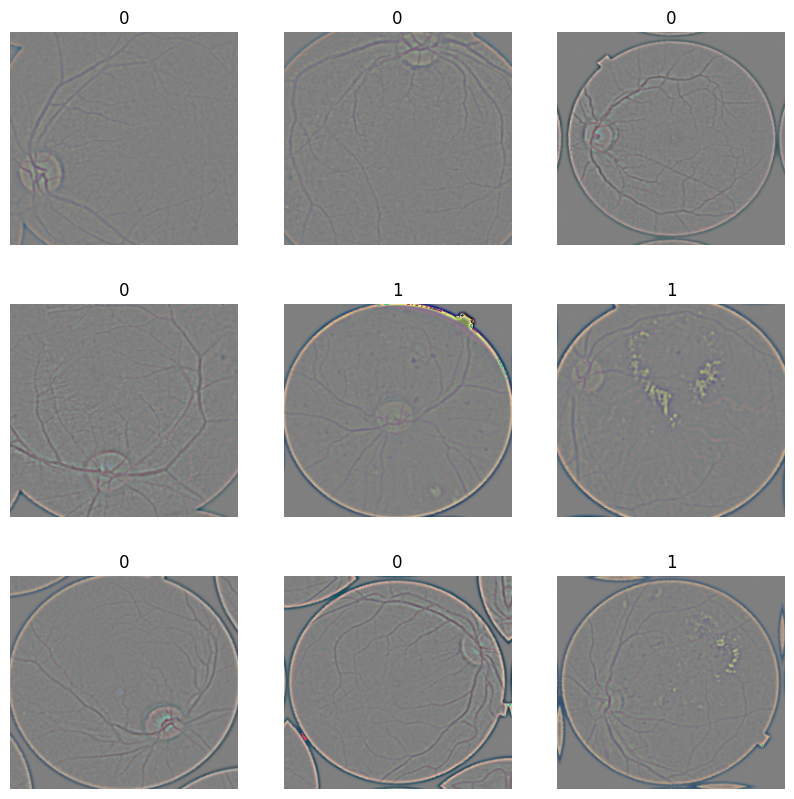

In [21]:
visualize_dataset(val_dataset)

# SEGMENTATION

In [11]:
from seg_train_generator import *

In [12]:
image_dir = config.TRAIN_DIR_SEG
label_dir = config.LABEL_DIR_SEG 
shuffle = False # if True shuffles the dataframe
df = create_df(image_dir, label_dir ,shuffle)

In [13]:
def visualize_dataset_seg(dataset):
    import matplotlib.pyplot as plt

    data_set_label = dataset[1]
    data_set_train = dataset[0]
    
    fig, axs = plt.subplots(nrows=5, ncols=2, figsize=(10, 20))
    for y in range(5):
        #axs[y, 0].subplot(5, 2, y+1)
        axs[y, 0].imshow(data_set_train[y])
        #plt.subplot(5, 2, y+2)
        axs[y, 1].imshow(data_set_label[y])
    
    plt.tight_layout()
    plt.show()
        
        

In [14]:
train_split = 0.8 
test_split = 0.1
batch_size = 5
height = 256
width = 256
channels = 3 
image_shape = (height, width) 

In [15]:
gen = jpgen(df, train_split=train_split, test_split=test_split)

In [16]:
tr_gen_len = gen.tr_gen_len

test_gen_len = gen.test_gen_len

valid_gen_len = gen.valid_gen_len   


In [17]:
# instantiate generators
train_gen = gen.flow(batch_size=batch_size, image_shape=image_shape, shuffle=False, subset='training', random_factor=0.7)
valid_gen = gen.flow(batch_size=batch_size, image_shape=image_shape, shuffle=False, subset='valid', random_factor=0.7)
test_gen = gen.flow(batch_size=batch_size, image_shape=image_shape, shuffle=False, subset='test', random_factor=0.7)

In [18]:
a = next(train_gen)]
visualize_dataset_seg(a)